<a href="https://colab.research.google.com/github/jlab-sensing/MFC_Modeling/blob/main/tsrv6_lstm15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade hepml
!pip install arrow
!pip install keras_lr_finder
# reload modules before executing user code
#%load_ext autoreload
# reload all modules every time before executing Python code
#%autoreload 2
# render plots in notebook
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip drive/MyDrive/"jLab Shared Docs"/"MFC Modeling"/stanfordMFCDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=63bc786bd334296b041536857cb299dc977ffb484680b894679f177c85dbe291
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97

In [ ]:
!pip freeze > requirements.txt

In [ ]:
#Load teros data
import glob
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [ ]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in sorted(power_files, key=lambda x: int(x.split('.')[0].split('_')[-1])):
#in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [ ]:
#Convert current to amps, voltage to volts
y["I1L [10pA]"] = np.abs(y["I1L [10pA]"] * 1E-11)
y["V1 [10nV]"] = np.abs(y["V1 [10nV]"] * 1E-8)
y["I1H [nA]"] = np.abs(y["I1H [nA]"] * 1E-9)

In [ ]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
uncut_df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('1 sec'), on = 'timestamp').dropna(how='all')

#Isolate data from cell0
df = uncut_df.loc[uncut_df['sensorID'] == 0]

#Localize timestamp
df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

<ipython-input-5-38f7a5b5fe7c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')


In [ ]:
#Use only data from after deployment date
#df = df.loc[(df['timestamp'] > '2021-09-24') & (df['timestamp'] < '2021-10-15')] #Future of Clean Computing Graph
#df = df.loc[(df['timestamp'] > '2021-06-24') & (df['timestamp'] < '2021-07-02')]
#df = df.loc[(df['timestamp'] > '2021-06-18')] #Two weeks after deployment
df = df.loc[(df['timestamp'] < '2021-06-04')] #Deployment date
#df = df.loc[(df['timestamp'] > '2021-06-25') & (df['timestamp'] < '2021-06-26')] #Small training set

#Power drop
#df = df.loc[(df['timestamp'] > '2021-11-01') & (df['timestamp'] < '2021-11-22')]

#Drop data outages
df = df.drop(df[(df.timestamp > '2021-11-11') & (df.timestamp < '2021-11-22 01:00:00')].index)
df = df.drop(df[(df.timestamp > '2022-01-27')].index)
#df = df.set_index('timestamp')
df = df[:-1]

In [ ]:
df = df.set_index('timestamp')

In [ ]:
#Get time since deployement
df['tsd'] = (df.index - df.index[0]).days
df['hour'] = (df.index).hour

In [ ]:
#Calculate power
df["power"] = np.abs(np.multiply(df.iloc[:, 7], df.iloc[:, 8]))
#df["power"] = np.abs(np.multiply(df["I1L [10pA]"], df["V1 [10nV]"]))

#Convert to nW
df['power'] = df['power']*1E9

In [ ]:
#Convert to 10 nanoamps, 10 microvolts
df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 1E8)
df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 1E5)
df["I1H [nA]"] = np.abs(df["I1H [nA]"] * 1E8)

In [ ]:
df = df.reset_index()

In [ ]:
#Add power time series
df['power - 1h'] = df['power'].shift(1).dropna()
df['power - 2h'] = df['power'].shift(2).dropna()
df['power - 3h'] = df['power'].shift(3).dropna()
#df['power - 2h'] = df['power'].shift(2).dropna()
#df['previous_power - 3'] = df['power'].shift(3).dropna()
#df['previous_power - 4'] = df['power'].shift(4).dropna()

#Add teros time series
df['EC - 1h'] = df['EC'].shift(1).dropna()
df['EC - 2h'] = df['EC'].shift(2).dropna()
df['EC - 3h'] = df['EC'].shift(3).dropna()

df['temp - 1h'] = df['temp'].shift(1).dropna()
df['temp - 2h'] = df['temp'].shift(2).dropna()
df['temp - 3h'] = df['temp'].shift(3).dropna()

df['raw_VWC - 1h'] = df['raw_VWC'].shift(1).dropna()
df['raw_VWC - 2h'] = df['raw_VWC'].shift(2).dropna()
df['raw_VWC - 3h'] = df['raw_VWC'].shift(3).dropna()

#Add voltage and current time series
df['V1 - 1h'] = df['V1 [10nV]'].shift(1).dropna()
df['V1 - 2h'] = df['V1 [10nV]'].shift(2).dropna()
df['V1 - 3h'] = df['V1 [10nV]'].shift(3).dropna()

df['I1L - 1h'] = df['I1L [10pA]'].shift(1).dropna()
df['I1L - 2h'] = df['I1L [10pA]'].shift(2).dropna()
df['I1L - 3h'] = df['I1L [10pA]'].shift(3).dropna()

df['I1H - 1h'] = df['I1H [nA]'].shift(1).dropna()
df['I1H - 2h'] = df['I1H [nA]'].shift(2).dropna()
df['I1H - 3h'] = df['I1H [nA]'].shift(3).dropna()
df = df.dropna()

In [ ]:
#df = df.rename(columns={'power': 'power [μW]'})
df = df.rename(columns={'I1L [10pA]': 'I1L [μA]', 'V1 [10nV]' : 'V1 [mV]'})
df = df.set_index('timestamp')

In [ ]:
X = pd.concat([df["power - 1h"], df["power - 2h"], df["power - 3h"], df["V1 - 1h"], df["V1 - 2h"], df["V1 - 3h"], df["I1L - 1h"], df["I1L - 2h"], df["I1L - 3h"],df["EC - 1h"], df["EC - 2h"], df["EC - 3h"], df["raw_VWC - 1h"], df["raw_VWC - 2h"], df["raw_VWC - 3h"], df["temp - 1h"], df["temp - 2h"], df["temp - 3h"], df["tsd"], df["hour"]], axis = 1)
y = pd.concat([df["power"], df['V1 [mV]'], df['I1L [μA]']], axis = 1)

In [ ]:
df

,sensorID,raw_VWC,temp,EC,I1L_valid,I2L_valid,I1H [nA],I1L [μA],V1 [mV],V2 [10nV],...,raw_VWC - 3h,V1 - 1h,V1 - 2h,V1 - 3h,I1L - 1h,I1L - 2h,I1L - 3h,I1H - 1h,I1H - 2h,I1H - 3h
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-04 00:00:50-07:00,0.0,2725.28,21.0,573.0,1.0,1.0,14536.3,9453.260,30977.020,39359957.0,...,2725.07,30977.388,30979.969,30982.181,9297.348,9252.394,8873.620,13982.8,13862.6,13717.2
2021-06-04 00:01:04-07:00,0.0,2726.09,21.0,565.0,1.0,1.0,15007.6,10077.188,30968.787,39353470.0,...,2725.49,30977.020,30977.388,30979.969,9453.260,9297.348,9252.394,14536.3,13982.8,13862.6
2021-06-04 00:01:17-07:00,0.0,2724.75,21.0,564.0,1.0,1.0,14191.6,9313.314,30978.863,39361793.0,...,2724.93,30968.787,30977.020,30977.388,10077.188,9453.260,9297.348,15007.6,14536.3,13982.8
2021-06-04 00:01:31-07:00,0.0,2725.98,21.0,573.0,1.0,1.0,14201.1,9269.745,30978.003,39362038.0,...,2725.28,30978.863,30968.787,30977.020,9313.314,10077.188,9453.260,14191.6,15007.6,14536.3
2021-06-04 00:01:45-07:00,0.0,2725.97,21.0,568.0,1.0,1.0,13834.2,8806.478,30983.655,39365832.0,...,2726.09,30978.003,30978.863,30968.787,9269.745,9313.314,10077.188,14201.1,14191.6,15007.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26 23:58:52-08:00,0.0,2656.71,9.7,177.0,1.0,1.0,30818.6,37668.539,2438.569,-2203527.0,...,2655.04,1050.016,1085.037,1041.168,4795.271,5386.144,4644.581,11481.0,12208.5,11209.0
2022-01-26 23:59:06-08:00,0.0,2656.16,9.7,180.0,1.0,1.0,6177.0,488.503,855.004,-3518080.0,...,2655.46,2438.569,1050.016,1085.037,37668.539,4795.271,5386.144,30818.6,11481.0,12208.5
2022-01-26 23:59:19-08:00,0.0,2655.98,9.7,176.0,1.0,1.0,6407.9,232.430,855.250,-3512450.0,...,2655.83,855.004,2438.569,1050.016,488.503,37668.539,4795.271,6177.0,30818.6,11481.0


In [ ]:
#New runtime calculation
import math
from dateutil import parser
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

def internal_R_v3(R=2000): #return internal resistance of v3 cells in ohms
    #https://www.jstage.jst.go.jp/article/jwet/20/1/20_21-087/_pdf
    v0_oc = 48.5e-3 #48.5 mV
    v0_cc = 4.8e-3
    v0_r = R*((v0_oc/v0_cc)-1)

    v1_oc = 43.8e-3
    v1_cc = 20.9e-3
    v1_r = R*((v1_oc/v1_cc)-1)

    v2_oc = 45.2e-3
    v2_cc = 23.5e-3
    v2_r = R*((v2_oc/v2_cc)-1)

    return (v0_r+v1_r+v2_r)/3

def internal_R_v0(R=2000): #return internal resistance of v0 cells in ohms
    v3_oc = 41.7e-3 #41.7mV
    v3_cc = 5.1e-3
    v3_r = R*((v3_oc/v3_cc)-1)

    v4_oc = 48.7e-3
    v4_cc = 16.8e-3
    v4_r = R*((v4_oc/v4_cc)-1)

    v5_oc = 39.1e-3
    v5_cc = 16.9e-3
    v5_r = R*((v5_oc/v5_cc)-1)

    return (v3_r+v4_r+v5_r)/3

def SMFC_current(v, R):
    return v/R

#MODEL
def cap_leakage(E_cap_tn, timestep):
    #Spec for KEMET T491
    return 0.01e-6 * E_cap_tn * timestep

def Matrix_Power(V, R):
    #efficiency interpolated from https://www.analog.com/media/en/technical-documentation/data-sheets/ADP5091-5092.pdf
    #given I_in = 100 uA and SYS = 3V
    #V is the voltage (V) of the SMFC we captured
    #R is the resistance (ohms) of the load we used to get that voltage trace
    #Eta = -292.25665*V**4 + 784.30311*V**3 - 770.71691*V**2 + 342.00502*V + 15.83307
    #Eta = Eta/100
    Eta = 0.60
    Pmax = (V**2)/R
    Pout = Eta*Pmax
    #assert((Eta > 0) & (Eta < 1))
    #assert(Pout < 12000e-6)
    return Pout

def update_capEnergy(e0, V_applied, R, C, dt):
    # e0: initial energy stored
    # V_applied: voltage from SMFC
    # R: internal resistance of SMFC
    # C: capacitance of capacitor
    # dt: time step since last data point
    e_cap = e0 + Matrix_Power(V_applied, R)*dt - cap_leakage(e0, dt)
    v_cap = math.sqrt(2*e_cap/C)
    if e_cap < 0: #Not charging if leakage is greater than energy
        e_cap = 0

    return e_cap, v_cap #output final e and v

def Advanced_energy():
    #Now representing "Advanced"
    #startup time of 2500 ms
    t = 2500e-3
    e = 2.4 * 128e-3 * t
    e_startup = 2.4 * 128e-3 * 5e-3
    return e+e_startup

def Minimal_energy():
    #Now representing "Minimal"
    t = 0.888e-3 #tentative time
    e = 0.9 * 4.8e-3 * t #this uses average current
    e_startup = 0#assume negligible, no known startup time given
    return  e + e_startup

def Analog_energy():
    #Now representing Analog
    t = 1e-3 #estimated operating time
    e = 0.11 * 2.15e-6 * t
    e_startup = 0 #analog device, no startup needed :)
    return e + e_startup

#STEP 3:
# For each day:
#   on_Minimal, on_Advanced, on_Analog = 0
#   For each time step (like every 60 s given our logging freq):
#       - Update the energy in our capacitor (put fcn in models.py) given (1) input voltage, (2) time step, (3) capacitance (prob 10 uF), this will be an integral
#       - Check if energy is enough to turn on (1) 1 uJ load, (2) 10 uJ load, and (3) 20 uJ load (will tweak later to reflect real energy cost of each system)
#       - If so, add to on_Minimal, on_Advanced, and on_Analog and reset capacitor energy to 0 J (might tweak this value)
#   Append on_Minimal, on_Advanced, on_Analog to on_Minimal_list, on_Advanced_list, on_Analog_list. This will be a list of how many sensor readings we are able to take with each of these systems every day given the energy we got
#STEP 4: Visualize the daily # of readings with 3 bar graphs, y axis is # of readings and x axis is days.
#   - Given 3 lists of integer values, plot them on bar graphs

def group_util(test_date1, test_date2, N):
    diff = (test_date2 - test_date1) / N
    return [test_date1 + diff * idx for idx in range(N)] + [test_date2]

def oracle_simulate(v_list, C_h):
    #Calculate maximum energy
    total_E = 0
    for i in range(len(v_list) - 1):
        t = (v_list.index[i+1] - v_list.index[i]).total_seconds()
        if t > 180:
          print("Discontinuity")
          print(v_list.index[i+1], v_list.index[i])
          print(v_list['V1 [mV]'][i+1], v_list['V1 [mV]'][i])
          #total_E, ignore = update_capEnergy(total_E, V_applied=(v_list['V1 [mV]'][i+1] + v_list['V1 [mV]'][i])/2, R=internal_R_v0(), C=C_h[0], dt = t)
        else:
          total_E, ignore = update_capEnergy(total_E, V_applied=(v_list['V1 [mV]'][i+1] + v_list['V1 [mV]'][i])/2, R=internal_R_v0(), C=C_h[0], dt = t)
    print("Oracle activations:", math.floor(total_E/Minimal_energy()))
    return(math.floor(total_E/Minimal_energy()))

def naive_simulate(t_list, v_list, v_list_naive, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_naive = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    total_E = 0
    #for each voltage data point
    v = v_list_naive.mean()
    for jj in range(len(v_list) - 1): #last data point was at 71.85893518518519 day
        t = (v_list.index[jj+1] - v_list.index[jj]).total_seconds()
        if t < 9000:
          #Total predicted vs. actual energy stored
          #print(t_list[jj+1], t_list[jj], t)
          #print("v_list:", v_list[jj])
          #print("v_list_pred:", v_list_pred[jj])
          total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
          total_E_naive, ignore = update_capEnergy(total_E_naive, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = t)
          #Predict energy stored during scheduled sub-interval
          E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
          pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
          if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
              minimal_intervals = [date for date in group_util(v_list.index[jj], v_list.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
              #if t > 9000:
              #      print(len(minimal_intervals))
              #      print(v_list_fine.iloc[v_list_fine.index.searchsorted(minimal_intervals[0]):v_list_fine.index.searchsorted(minimal_intervals[-1])])
              for i in range(len(minimal_intervals) - 1):
                  #Determine actual energy stored during scheduled sub-interval
                  start = v_list_fine.index.searchsorted(minimal_intervals[i])
                  end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])
                  #for h in range(start, end):
                  #  v = v_list_fine.iloc[h]['V1 [10nV]']
                  #  interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
                  #  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
                  #  e_minimal_stored = E_Minimal
                  if not math.isnan(v_list_fine.iloc[start:end]['V1 [mV]'].mean()):
                    interval_length = (minimal_intervals[i+1] - minimal_intervals[i]).total_seconds()
                    E_Minimal, v_minimal = update_capEnergy(e_minimal_stored, V_applied=v_list_fine.iloc[start:end]['V1 [mV]'].mean(), R=internal_R_v0(), C=C_h[0], dt = interval_length)
                    if E_Minimal < Minimal_energy():
                        false_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())

                    elif E_Minimal >= Minimal_energy():
                        succ_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                    else:
                      print('Error')
                      print(v_list_fine.iloc[start:end]['V1 [mV]'].mean())

          else:
              e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
              #start = y_valid.index.searchsorted(v_list.index[jj])
              #end =  y_valid.index.searchsorted(v_list.index[jj] + timedelta(seconds=t))
              #for h in range(start, end):
              #  v = v_list_fine.iloc[h]['V1 [10nV]']
              #  interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
              #  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
              #  e_minimal_stored = E_Minimal

    print("Naive total_E activations:", total_E/Minimal_energy())
    print("Naive total_E_pred activations:", total_E_naive/Minimal_energy())
    return pred_act, false_act, succ_act, total_E_naive

def getMax(c_list, input_list):
    max_value = max(input_list)
    i = [index for index, item in enumerate(input_list) if item == max_value][0]
    return i, max_value, c_list[i]


#SMFC
import csv
from collections import defaultdict
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime

def butter_lowpass(cutoff, fs, order=5):
        return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def getMFC_data(y_test, test_pred):
    unix_time = y_test.index
    d0 = unix_time[0]
    days = []
    for d in unix_time:
        day = d
        day_from_start = day-d0
        decimal_day = day_from_start.total_seconds()/(24 * 3600)
        days.append(decimal_day)

    return days

In [ ]:
def simulate(t_list, v_list, v_list_pred, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_pred = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    total_E = 0
    #for each voltage data point
    for jj in range(len(v_list) - 1): #last data point was at 71.85893518518519 day
        t = (v_list.index[jj+1] - v_list.index[jj]).total_seconds()
        total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        total_E_pred, ignore = update_capEnergy(total_E_pred, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        if t <= 180:
          #Total predicted vs. actual energy stored
          #Predict energy stored during scheduled sub-interval
          E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
          pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
          itn = 0
          if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
              minimal_intervals = [date for date in group_util(v_list_pred.index[jj], v_list_pred.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
              int_len = 180 /  math.floor(E_Minimal_pred/Minimal_energy())
              for i in range(len(minimal_intervals) - 1):
                  #Determine actual energy stored during scheduled sub-interval
                  start = v_list_fine.index.searchsorted(minimal_intervals[i])
                  end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])
                  v = v_list_fine.iloc[start:end]['V1 [mV]'].mean()

                  #interval_length = ((v_list_fine.index[end]) - (v_list_fine.index[start])).total_seconds()
                  #if interval_length > int_len:
                  #  print('interval_length > int_len')
                  #  print('interval_length, int_len:', interval_length, int_len)
                  #  print(v_list_fine.index[start], v_list_fine.index[end])
                  #else:
                  #  print('interval_length <= int_len')
                  #  print('interval_length, int_len:', interval_length, int_len)
                  #  print(v_list_fine.index[start], v_list_fine.index[end])

                  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = int_len)
                  if not math.isnan(v_list_fine.iloc[start:end]['V1 [mV]'].mean()):
                    if E_Minimal < Minimal_energy():
                        false_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn += 1

                    elif E_Minimal >= Minimal_energy():
                        succ_act += 1
                        e_minimal_stored = max(0, E_Minimal - Minimal_energy())
                        itn+= 1

                    else:
                      print('Error')
                      print(e_minimal_stored, v)

                  #Unit test
                  #else:
                  #  print("?")
                  #  print(v_list_fine.index[start])
                  #  print(v_list_fine.index[end])
                  #  print(minimal_intervals[i], minimal_intervals[i+1])

              #Unit test
              #if itn != math.floor(E_Minimal_pred/Minimal_energy()):
              #    print("itn not matching")
              #    print(itn, math.floor(E_Minimal_pred/Minimal_energy()))
              #    continue

          else:
              e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
              #Added this
              #start = v_list_fine.index.searchsorted(v_list.index[jj])
              #end =  v_list_fine.index.searchsorted(v_list.index[jj+1])
              #for h in range(start, end):
              #    v = v_list_fine.iloc[h]['V1 [mV]']
              #    interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
              #    E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
              #    e_minimal_stored = E_Minimal


        else:
          print("It's over 9000!", v_list.index[jj], v_list.index[jj+1])

    print("Runtime total_E activations:", total_E/Minimal_energy())
    print("Runtime total_E_pred activations:", total_E_pred/Minimal_energy())
    return pred_act, false_act, succ_act, total_E, total_E_pred

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

power_mape = []
voltage_mape = []
current_mape = []

E_actual_list = []
E_pred_list = []

max_act_list = []
pred_act_list = []
succ_act_list = []

pred_act_naive_list = []
false_act_naive_list = []
succ_act_naive_list = []

#Set parameters
batchsize = 300
time_frame = '3min'
n = 0
splits = TimeSeriesSplit(n_splits=4)
for train_index, test_index in splits.split(X):
  n += 1
  if n >= 1:
    #Split train and test sets
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
    y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

    #Set dataset bounds
    train_bound_lower = y_train.index[0]
    train_bound_upper = y_train.index[-1]
    valid_bound_lower = y_valid.index[0]
    valid_bound_upper = y_valid.index[-1]
    test_bound_lower = y_test.index[0]
    test_bound_upper = y_test.index[-1]

    #Resample data
    X_train = X_train.resample(time_frame).mean().dropna()
    X_valid = X_valid.resample(time_frame).mean().dropna()
    X_test = X_test.resample(time_frame).mean().dropna()

    y_train = y_train.resample(time_frame).mean().dropna()
    y_valid = y_valid.resample(time_frame).mean().dropna()
    y_test = y_test.resample(time_frame).mean().dropna()

    #Reshape data
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

    print("Train set size:", len(y_train))
    print("Test set size:", len(y_test))



    def quantile_loss(y_true, y_pred, quantile = 0.05):
      error = y_true - y_pred
      return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

    # design network
    model = Sequential()
    model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(3))
    model.compile(loss=quantile_loss, metrics=['mape'], optimizer='adam')


    # fit network
    model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid), batch_size=batchsize, verbose=2, shuffle=False)

    train_pred = model.predict(X_train, batch_size=batchsize)
    test_pred = model.predict(X_test, batch_size=batchsize)

    #Prepare data for runtime simulation
    y_test['power pred'] = test_pred[:, 0]
    y_test['V1 [mV] pred'] = test_pred[:, 1]
    y_test['I1L [μA] pred'] = test_pred[:, 2]

    days  = getMFC_data(y_test, test_pred)

    v_test = df.loc[(((df.index >= test_bound_lower)) & (df.index <= test_bound_upper))]['V1 [mV]']
    v_test = v_test.drop(v_test[(v_test.index > '2021-11-11') & (v_test.index < '2021-11-22 01:00:00')].index)
    v_test = pd.DataFrame(v_test)/1E5
    v_avg_true = v_test['V1 [mV]'].resample(time_frame).mean().dropna()
    v_avg_pred = y_test['V1 [mV] pred']/1E5
    C0 = [0.007000000000000006, 0.007000000000000006, 0.007000000000000006]

    #Remove first and last entries of averaged data to prevent overestimation of available energy
    v_avg_true = v_avg_true[1:][:-1]
    v_avg_pred = v_avg_pred[1:][:-1]

    #Run oracle model
    max_act = oracle_simulate(v_test, C0)

    #Call simulate function
    pred_act, false_act, succ_act, total_E, total_E_pred = simulate(days, v_avg_true, v_avg_pred, v_test, C0)

    #Run naive model
    v_valid = df.loc[(((df.index >= valid_bound_lower)) & (df.index < valid_bound_upper))]['V1 [mV]']/1E5
    pred_act_naive, false_act_naive, succ_act_naive, total_E = naive_simulate(days, v_avg_true, v_valid, v_test, C0)
    print("Dataset, train set, and test set size:", len(y_train) + len(y_valid) + len(y_test), len(y_train), len(y_test))
    print('Timeframe:', time_frame)

    print('Minimal Application')
    print("Naive vs. DL succesful activations:", succ_act/succ_act_naive)
    #print('Predicted vs. Actual percent difference: %.3f%%' % ((total_E * 100 / total_E_pred) - 100))
    print('Maximum possible activations:', max_act)
    print('Predicted activations:', pred_act)
    print('Successful activations: %d, %.3f%%' % (succ_act, succ_act * 100/pred_act))
    print('Failed activations: %d, %.3f%%' % (false_act, false_act * 100/pred_act))
    print('Missed activations: %d, %.3f%%' % (max_act - succ_act, (max_act - succ_act) * 100/max_act))

    #Naive model
    print('Naive predicted activations (usual actual energy average):', pred_act_naive)
    print('Naive successful activations (usual actual energy average): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/pred_act_naive))
    print('Naive failed activations (usual actual energy average): %d, %.3f%%' % (false_act_naive, false_act_naive * 100/pred_act_naive))
    print('Naive missed activations (usual actual energy average): %d, %.3f%%' % (max_act - succ_act_naive, (max_act - succ_act_naive) * 100/max_act))


    print('Voltage overestimation rate: %.3f%%' % ((y_test['V1 [mV]'].values <= y_test['V1 [mV] pred']).mean() * 100))
    print("Test MAPE power: %3f" %  MAPE(y_test['power'].values.ravel(), y_test['power pred']))
    print("Test MAPE voltage: %3f" % MAPE(y_test['V1 [mV]'], y_test['V1 [mV] pred']))
    print("Test MAPE current: %3f" % MAPE(y_test['I1L [μA]'], y_test['I1L [μA] pred']))

Train set size: 14677
Test set size: 7359
Epoch 1/25
49/49 - 4s - loss: 87.8286 - mape: 48.0673 - val_loss: 28.3328 - val_mape: 31.3039 - 4s/epoch - 90ms/step
Epoch 2/25
49/49 - 1s - loss: 70.3953 - mape: 38.1516 - val_loss: 20.7803 - val_mape: 21.9396 - 1s/epoch - 27ms/step
Epoch 3/25
49/49 - 1s - loss: 42.8194 - mape: 35.9070 - val_loss: 17.3945 - val_mape: 17.3837 - 1s/epoch - 30ms/step
Epoch 4/25
49/49 - 1s - loss: 60.9460 - mape: 37.5079 - val_loss: 19.2826 - val_mape: 23.3734 - 1s/epoch - 30ms/step
Epoch 5/25
49/49 - 1s - loss: 46.7478 - mape: 27.3743 - val_loss: 16.0629 - val_mape: 21.4636 - 1s/epoch - 30ms/step
Epoch 6/25
49/49 - 1s - loss: 31.1846 - mape: 25.2757 - val_loss: 13.3987 - val_mape: 15.5582 - 1s/epoch - 30ms/step
Epoch 7/25
49/49 - 1s - loss: 80.2455 - mape: 39.2869 - val_loss: 27.8264 - val_mape: 26.4576 - 1s/epoch - 30ms/step
Epoch 8/25
49/49 - 1s - loss: 43.2807 - mape: 31.6985 - val_loss: 16.0047 - val_mape: 18.3180 - 1s/epoch - 31ms/step
Epoch 9/25
49/49 - 2s 

In [ ]:
v_avg_true

timestamp
2021-08-12 23:18:00-07:00    0.022662
2021-08-12 23:21:00-07:00    0.022647
2021-08-12 23:24:00-07:00    0.022891
2021-08-12 23:27:00-07:00    0.023224
2021-08-12 23:30:00-07:00    0.022799
                               ...   
2021-10-05 04:30:00-07:00    0.030337
2021-10-05 04:33:00-07:00    0.029895
2021-10-05 04:36:00-07:00    0.030100
2021-10-05 04:39:00-07:00    0.029709
2021-10-05 04:42:00-07:00    0.029990
Name: V1 [mV], Length: 7357, dtype: float64

In [ ]:
v_avg_true[1:][:-1]

timestamp
2021-12-12 01:51:00-08:00    0.042887
2021-12-12 01:54:00-08:00    0.043115
2021-12-12 01:57:00-08:00    0.043433
2021-12-12 02:00:00-08:00    0.044432
2021-12-12 02:03:00-08:00    0.044542
                               ...   
2021-12-27 08:30:00-08:00    0.011772
2021-12-27 08:33:00-08:00    0.011377
2021-12-27 08:36:00-08:00    0.011526
2021-12-27 08:39:00-08:00    0.011652
2021-12-27 08:42:00-08:00    0.011742
Freq: 3T, Name: V1 [mV], Length: 7338, dtype: float64

In [ ]:
for i in range(len(v_test.index) - 1):
  if (v_test.index[i+1] - v_test.index[i]).total_seconds() > 30:
    print(v_test.index[i+1], v_test.index[i])



2021-12-25 19:31:52-08:00 2021-12-25 19:30:44-08:00


In [ ]:
v_test.index[0]

Timestamp('2021-12-12 01:50:03-0800', tz='US/Pacific')

In [ ]:
v_avg_true

timestamp
2021-12-12 01:48:00-08:00    0.042680
2021-12-12 01:51:00-08:00    0.042887
2021-12-12 01:54:00-08:00    0.043115
2021-12-12 01:57:00-08:00    0.043433
2021-12-12 02:00:00-08:00    0.044432
                               ...   
2021-12-27 08:30:00-08:00    0.011772
2021-12-27 08:33:00-08:00    0.011377
2021-12-27 08:36:00-08:00    0.011526
2021-12-27 08:39:00-08:00    0.011652
2021-12-27 08:42:00-08:00    0.011742
Freq: 3T, Name: V1 [mV], Length: 7339, dtype: float64

In [ ]:
v_avg_pred

timestamp
2021-12-12 01:48:00-08:00    0.034146
2021-12-12 01:51:00-08:00    0.034819
2021-12-12 01:54:00-08:00    0.034582
2021-12-12 01:57:00-08:00    0.036043
2021-12-12 02:00:00-08:00    0.036840
                               ...   
2021-12-27 08:30:00-08:00    0.010847
2021-12-27 08:33:00-08:00    0.011536
2021-12-27 08:36:00-08:00    0.010602
2021-12-27 08:39:00-08:00    0.010739
2021-12-27 08:42:00-08:00    0.010621
Freq: 3T, Name: V1 [mV] pred, Length: 7339, dtype: float32

In [ ]:
v_test

,V1 [mV]
timestamp,
2021-12-12 01:50:03-08:00,0.041934
2021-12-12 01:50:17-08:00,0.043989
2021-12-12 01:50:31-08:00,0.042013
2021-12-12 01:50:44-08:00,0.041475
2021-12-12 01:50:58-08:00,0.043989
...,...
2021-12-27 08:43:53-08:00,0.014330
2021-12-27 08:44:07-08:00,0.011629
2021-12-27 08:44:21-08:00,0.012309


In [ ]:
v_avg_true.index

DatetimeIndex(['2022-01-11 16:18:00-08:00', '2022-01-11 16:21:00-08:00',
               '2022-01-11 16:24:00-08:00', '2022-01-11 16:27:00-08:00',
               '2022-01-11 16:30:00-08:00', '2022-01-11 16:33:00-08:00',
               '2022-01-11 16:36:00-08:00', '2022-01-11 16:39:00-08:00',
               '2022-01-11 16:42:00-08:00', '2022-01-11 16:45:00-08:00',
               ...
               '2022-01-26 23:30:00-08:00', '2022-01-26 23:33:00-08:00',
               '2022-01-26 23:36:00-08:00', '2022-01-26 23:39:00-08:00',
               '2022-01-26 23:42:00-08:00', '2022-01-26 23:45:00-08:00',
               '2022-01-26 23:48:00-08:00', '2022-01-26 23:51:00-08:00',
               '2022-01-26 23:54:00-08:00', '2022-01-26 23:57:00-08:00'],
              dtype='datetime64[ns, US/Pacific]', name='timestamp', length=7354, freq='3T')

In [ ]:
v_avg_pred

timestamp
2021-12-12 01:48:00-08:00    0.042024
2021-12-12 01:51:00-08:00    0.042606
2021-12-12 01:54:00-08:00    0.042404
2021-12-12 01:57:00-08:00    0.042549
2021-12-12 02:00:00-08:00    0.043646
                               ...   
2021-12-27 08:30:00-08:00    0.011390
2021-12-27 08:33:00-08:00    0.011344
2021-12-27 08:36:00-08:00    0.010932
2021-12-27 08:39:00-08:00    0.011157
2021-12-27 08:42:00-08:00    0.011242
Freq: 3T, Name: V1 [mV] pred, Length: 7339, dtype: float32

In [ ]:
X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=False)
y_valid, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

In [ ]:
valid_bound_lower = y_valid.index[0]
valid_bound_upper = y_valid.index[-1]
test_bound_lower = y_test.index[0]
test_bound_upper = y_test.index[-1]

In [ ]:
time_frame = '60min'

X_train = X_train.resample(time_frame).mean()
X_valid = X_valid.resample(time_frame).mean()
X_test = X_test.resample(time_frame).mean()

y_train = y_train.resample(time_frame).mean()
y_valid = y_valid.resample(time_frame).mean()
y_test = y_test.resample(time_frame).mean()

In [ ]:
#reshape data
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def custom_loss(y_true, y_pred):
    residual = (y_true - y_pred*1.11).astype("float")
    loss = tf.where(residual < 0, (residual**2) * 1, residual**2)
    return loss

In [ ]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def custom_loss(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = tf.math.sqrt(tf.where(residual < 0, (residual**2), residual**2))
    return loss

In [ ]:
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def custom_loss(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = tf.where(residual < 0, tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred,y_true),(y_true + 1e-10)))) * 100, tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred,y_true),(y_true + 1e-10)))) * 100)
    return loss

In [ ]:
def quantile_loss(y_true, y_pred, quantile = 0.75):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

In [ ]:
from keras.models import load_model
model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/lstm8_60min_quant75", custom_objects={'quantile_loss': quantile_loss})
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

18/18 [==============================] - 0s 2ms/step


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import Input
from keras.models import Model
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(loss=quantile_loss, metrics=['mape'], optimizer='adam')

In [ ]:
X_train.shape

(2559, 1, 20)

In [ ]:
from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.3)

batchsize = 8
# fit network
model.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid), batch_size=batchsize, verbose=2, shuffle=False)

Epoch 1/25
320/320 - 6s - loss: 248.6508 - mape: 18.3042 - val_loss: 91.5237 - val_mape: 13.1559 - 6s/epoch - 20ms/step
Epoch 2/25
320/320 - 2s - loss: 156.1360 - mape: 18.4219 - val_loss: 79.2564 - val_mape: 11.4511 - 2s/epoch - 6ms/step
Epoch 3/25
320/320 - 1s - loss: 120.9987 - mape: 13.9169 - val_loss: 75.4047 - val_mape: 12.1010 - 1s/epoch - 4ms/step
Epoch 4/25
320/320 - 1s - loss: 103.2360 - mape: 11.7955 - val_loss: 81.9642 - val_mape: 16.6948 - 1s/epoch - 4ms/step
Epoch 5/25
320/320 - 1s - loss: 101.4126 - mape: 10.8723 - val_loss: 78.5507 - val_mape: 15.2109 - 1s/epoch - 4ms/step
Epoch 6/25
320/320 - 1s - loss: 108.1772 - mape: 11.9389 - val_loss: 76.0652 - val_mape: 14.0007 - 1s/epoch - 4ms/step
Epoch 7/25


KeyboardInterrupt: 

In [ ]:
def enable_dropout(model):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.training = True
def disable_dropout(model):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.training = False


In [ ]:
enable_dropout(model)

In [ ]:
num_samples = 100

test_predictions = []
for _ in range(num_samples):
    test_prediction = model.predict(X_test, verbose=0)
    test_predictions.append(test_prediction)

In [ ]:
prediction_std = np.std(test_predictions, axis=0)
prediction_mean = np.mean(test_predictions, axis=0)

In [ ]:
lower_bound = prediction_mean - 1.96 * prediction_std
upper_bound = prediction_mean + 1.96 * prediction_std

In [ ]:
#Define SMAPE
def SMAPE(actual, predicted):
    return 1/len(actual) * np.sum(2 * np.abs(predicted-actual) / (np.abs(actual) + np.abs(predicted))*100)

In [ ]:
drive.mount('/content/drive', force_remount=True)
model.save("lstm8_3min_quant75", overwrite=True, save_format=None)
!mv lstm8_3min_quant75 'drive/MyDrive/jLab Shared Docs/MFC Modeling'

Mounted at /content/drive


In [ ]:
train_pred = model.predict(X_train, batch_size=batchsize)
valid_pred = model.predict(X_valid, batch_size=batchsize)
test_pred = model.predict(X_test, batch_size=batchsize)

69/69 [==============================] - 0s 3ms/step


In [ ]:
#Evaluate SMAPE
#print("Train SMAPE:\n", SMAPE(y_train.values.ravel(), train_pred))
#print("Test SMAPE:\n", SMAPE(y_test.values.ravel(), test_pred))

#Evaluate MAPE
#print("Train MAPE power:\n", MAPE(y_train['power'].values.ravel(), train_pred))
#print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), test_pred))

print("Train MAPE power:\n", MAPE(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Valid MAPE power:\n", MAPE(y_valid['power'].values.ravel(), valid_pred[:, 0]))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), test_pred[:, 0]))

#Scaled
#print("Train MAPE power:\n", MAPE(y_train[:, 0], train_pred[:, 0]))
#print("Test MAPE power:\n", MAPE(y_test[:, 0], test_pred[:, 0]))

#Evalaute MAE
#print("Train MAE power:\n", mean_absolute_error(y_train['power'].values.ravel(), train_pred[:, 0]))
#print("Test MAE power:\n", mean_absolute_error(y_test['power'].values.ravel(), test_pred[:, 0]))

ValueError: Input contains NaN.

In [ ]:
#Evaluate MAPE
print("Train MAPE voltage:\n", MAPE(y_train['V1 [mV]'], train_pred[:, 1]))
print("Valid MAPE voltage:\n", MAPE(y_valid['V1 [mV]'], valid_pred[:, 1]))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [mV]'], test_pred[:, 1]))

#print("Train MAPE voltage:\n", MAPE(y_train['V1 [10nV]'].shift(1).dropna().values.ravel(), train_pred[:, 1][1:]))
#print("Test MAPE voltage:\n", MAPE(y_test['V1 [10nV]'].shift(1).dropna().values.ravel(), test_pred[:, 1][1:]))

#Evalaute MAE
#print("Train MAE voltage:\n", mean_absolute_error(y_train['V1 [mV]'].values.ravel(), train_pred[:, 1]))
#print("Test MAE voltage:\n", mean_absolute_error(y_test['V1 [mV]'].values.ravel(), test_pred[:, 1]))

ValueError: Input contains NaN.

In [ ]:
#Evaluate MAPE
print("Train MAPE current:\n", MAPE(y_train['I1L [μA]'], train_pred[:, 2]))
print("Valid MAPE current:\n", MAPE(y_valid['I1L [μA]'], valid_pred[:, 2]))
print("Test MAPE current:\n", MAPE(y_test['I1L [μA]'], test_pred[:, 2]))

#print("Train MAPE current:\n", MAPE(y_train['I1L [10pA]'].shift(1).dropna().values.ravel(), train_pred[:, 2][1:]))
#print("Test MAPE current:\n", MAPE(y_test['I1L [10pA]'].shift(1).dropna().values.ravel(), test_pred[:, 2][1:]))

#Evalaute MAE
#print("Train MAE current:\n", mean_absolute_error(y_train['I1L [μA]'].values.ravel(), train_pred[:, 2]))
#print("Test MAE current:\n", mean_absolute_error(y_test['I1L [μA]'].values.ravel(), test_pred[:, 2]))

Valid MAPE current:
 0.035445924693978094
Test MAPE current:
 0.04266828062561251


In [ ]:
#New runtime calculation
import math
from dateutil import parser
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

def internal_R_v3(R=2000): #return internal resistance of v3 cells in ohms
    #https://www.jstage.jst.go.jp/article/jwet/20/1/20_21-087/_pdf
    v0_oc = 48.5e-3 #48.5 mV
    v0_cc = 4.8e-3
    v0_r = R*((v0_oc/v0_cc)-1)

    v1_oc = 43.8e-3
    v1_cc = 20.9e-3
    v1_r = R*((v1_oc/v1_cc)-1)

    v2_oc = 45.2e-3
    v2_cc = 23.5e-3
    v2_r = R*((v2_oc/v2_cc)-1)

    return (v0_r+v1_r+v2_r)/3

def internal_R_v0(R=2000): #return internal resistance of v0 cells in ohms
    v3_oc = 41.7e-3 #41.7mV
    v3_cc = 5.1e-3
    v3_r = R*((v3_oc/v3_cc)-1)

    v4_oc = 48.7e-3
    v4_cc = 16.8e-3
    v4_r = R*((v4_oc/v4_cc)-1)

    v5_oc = 39.1e-3
    v5_cc = 16.9e-3
    v5_r = R*((v5_oc/v5_cc)-1)

    return (v3_r+v4_r+v5_r)/3

def SMFC_current(v, R):
    return v/R

#MODEL
def cap_leakage(E_cap_tn, timestep):
    #Spec for KEMET T491
    return 0.01e-6 * E_cap_tn * timestep

def Matrix_Power(V, R):
    #efficiency interpolated from https://www.analog.com/media/en/technical-documentation/data-sheets/ADP5091-5092.pdf
    #given I_in = 100 uA and SYS = 3V
    #V is the voltage (V) of the SMFC we captured
    #R is the resistance (ohms) of the load we used to get that voltage trace
    #Eta = -292.25665*V**4 + 784.30311*V**3 - 770.71691*V**2 + 342.00502*V + 15.83307
    #Eta = Eta/100
    Eta = 0.60
    Pmax = (V**2)/R
    Pout = Eta*Pmax
    #assert((Eta > 0) & (Eta < 1))
    #assert(Pout < 12000e-6)
    return Pout

def update_capEnergy(e0, V_applied, R, C, dt):
    # e0: initial energy stored
    # V_applied: voltage from SMFC
    # R: internal resistance of SMFC
    # C: capacitance of capacitor
    # dt: time step since last data point
    e_cap = e0 + Matrix_Power(V_applied, R)*dt - cap_leakage(e0, dt)
    v_cap = math.sqrt(2*e_cap/C)
    if e_cap < 0: #Not charging if leakage is greater than energy
        e_cap = 0

    return e_cap, v_cap #output final e and v

def Advanced_energy():
    #Now representing "Advanced"
    #startup time of 2500 ms
    t = 2500e-3
    e = 2.4 * 128e-3 * t
    e_startup = 2.4 * 128e-3 * 5e-3
    return e+e_startup

def Minimal_energy():
    #Now representing "Minimal"
    t = 0.888e-3 #tentative time
    e = 0.9 * 4.8e-3 * t #this uses average current
    e_startup = 0#assume negligible, no known startup time given
    return  e + e_startup

def Analog_energy():
    #Now representing Analog
    t = 1e-3 #estimated operating time
    e = 0.11 * 2.15e-6 * t
    e_startup = 0 #analog device, no startup needed :)
    return e + e_startup

#STEP 3:
# For each day:
#   on_Minimal, on_Advanced, on_Analog = 0
#   For each time step (like every 60 s given our logging freq):
#       - Update the energy in our capacitor (put fcn in models.py) given (1) input voltage, (2) time step, (3) capacitance (prob 10 uF), this will be an integral
#       - Check if energy is enough to turn on (1) 1 uJ load, (2) 10 uJ load, and (3) 20 uJ load (will tweak later to reflect real energy cost of each system)
#       - If so, add to on_Minimal, on_Advanced, and on_Analog and reset capacitor energy to 0 J (might tweak this value)
#   Append on_Minimal, on_Advanced, on_Analog to on_Minimal_list, on_Advanced_list, on_Analog_list. This will be a list of how many sensor readings we are able to take with each of these systems every day given the energy we got
#STEP 4: Visualize the daily # of readings with 3 bar graphs, y axis is # of readings and x axis is days.
#   - Given 3 lists of integer values, plot them on bar graphs

def group_util(test_date1, test_date2, N):
    diff = (test_date2 - test_date1) / N
    return [test_date1 + diff * idx for idx in range(N)] + [test_date2]

def simulate(t_list, v_list, v_list_pred, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    max_act = 0
    pred_act = 0
    succ_act = 0

    total_E = 0
    total_E_pred = 0

    #Calculate maximum energy
    #for i in range(len(v_list_fine) - 1):
    #    t = (v_list_fine.index[i+1] - v_list_fine.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_fine['V1 [10nV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    #print(total_E/Minimal_energy())
    total_E = 0
    #for each voltage data point
    for jj in range(len(t_list) - 1): #last data point was at 71.85893518518519 day
        t = (t_list[jj+1] - t_list[jj])*24*3600
        #Total predicted vs. actual energy stored
        total_E, ignore = update_capEnergy(total_E, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
        total_E_pred, ignore = update_capEnergy(total_E_pred, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t)

        #Predict energy stored during scheduled sub-interval
        E_Minimal_pred, v_minimal_pred = update_capEnergy(e_minimal_stored, V_applied=v_list_pred[jj], R=internal_R_v0(), C=C_h[0], dt = t) #set dt as length of prediction interval, in seconds
        pred_act += math.floor(E_Minimal_pred/Minimal_energy()) #Update number of activations predicted
        if math.floor(E_Minimal_pred/Minimal_energy()) > 0:
            minimal_intervals = [date.strftime("%Y/%m/%d %H:%M:%S") for date in group_util(v_list_pred.index[jj], v_list_pred.index[jj] + timedelta(seconds=t), math.floor(E_Minimal_pred/Minimal_energy()))]
            for i in range(len(minimal_intervals) - 1):
                #Determine actual energy stored during scheduled sub-interval
                start = v_list_fine.index.searchsorted(minimal_intervals[i])
                end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])
                #for h in range(start, end):
                #  v = v_list_fine.iloc[h]['V1 [10nV]']
                #  interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
                #  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
                #  e_minimal_stored = E_Minimal
                v = v_list_fine.iloc[start:end]['V1 [mV]'].mean()
                interval_length = (parser.parse(minimal_intervals[i+1]) - parser.parse(minimal_intervals[i])).total_seconds()
                E_Minimal, v_minimal = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
                if E_Minimal < Minimal_energy():
                    false_act += 1
                    e_minimal_stored = max(0, E_Minimal - Minimal_energy())

                elif E_Minimal >= Minimal_energy():
                    succ_act += 1
                    e_minimal_stored = max(0, E_Minimal - Minimal_energy())

        else:
            e_minimal_stored, ignore = update_capEnergy(e_minimal_stored, V_applied=v_list[jj], R=internal_R_v0(), C=C_h[0], dt = t)
            #start = y_valid.index.searchsorted(v_list.index[jj])
            #end =  y_valid.index.searchsorted(v_list.index[jj] + timedelta(seconds=t))
            #for h in range(start, end):
            #  v = v_list_fine.iloc[h]['V1 [10nV]']
            #  interval_length = ((v_list_fine.index[h+1]) - (v_list_fine.index[h])).total_seconds()
            #  E_Minimal, ignore = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)
            #  e_minimal_stored = E_Minimal

    print(total_E/Minimal_energy())
    print(total_E_pred/Minimal_energy())
    return pred_act, false_act, succ_act, total_E, total_E_pred

def oracle_simulate(v_list, C_h):
    #Calculate maximum energy
    total_E = 0
    for i in range(len(v_list) - 1):
        t = (v_list.index[i+1] - v_list.index[i]).total_seconds()
        total_E, ignore = update_capEnergy(total_E, V_applied=v_list['V1 [mV]'][i], R=internal_R_v0(), C=C_h[0], dt = t)
    print(math.floor(total_E/Minimal_energy()))
    return(math.floor(total_E/Minimal_energy()))

def naive_simulate(v_list, v_list_train, v_list_fine, C_h):
    # t_list: list of decimal time stamps in unit of days (e.g. 71.85893518518519 day), same length as v_list
    # v_list: list of voltage values from SFMC
    # C_h: capacitance of the capacitor being filled up by harvester

    #assume capacitor is completely discharged at start
    e_minimal_stored = 0
    e_minimal_stored_theo = 0

    #Initialize evaluation metrics
    false_act = 0
    pred_act = 0
    succ_act = 0

    power_list = []
    E_tot = 0
    total_E = 0

    #for i in range(len(v_list_train) - 1):
    #    t = (v_list_train.index[i+1] - v_list_train.index[i]).total_seconds()
    #    total_E, ignore = update_capEnergy(total_E, V_applied=v_list_train[i], R=internal_R_v0(), C=C_h[0], dt = t)
    t = (v_list_fine.index[-1] - v_list_fine.index[0]).total_seconds()
    total_E, ignore = update_capEnergy(0, V_applied=v_list_train.mean(), R=internal_R_v0(), C=C_h[0], dt = t)

    #Schedule activations with fixed-duty cycle based on total energy
    print(total_E)
    pred_act = math.floor(total_E/Minimal_energy())
    minimal_intervals = [date.strftime("%Y/%m/%d %H:%M:%S") for date in group_util(v_list_fine.index[0], v_list_fine.index[-1], pred_act)]
    for i in range(len(minimal_intervals) - 1):
        #Determine actual energy stored during scheduled sub-interval
        start = v_list_fine.index.searchsorted(minimal_intervals[i])
        end =  v_list_fine.index.searchsorted(minimal_intervals[i+1])
        v = v_list_fine.iloc[start:end]['V1 [mV]'].mean()
        interval_length = (parser.parse(minimal_intervals[i+1]) - parser.parse(minimal_intervals[i])).total_seconds()
        E_Minimal, v_minimal = update_capEnergy(e_minimal_stored, V_applied=v, R=internal_R_v0(), C=C_h[0], dt = interval_length)

        if (E_Minimal) < Minimal_energy():
            false_act += 1
            e_minimal_stored = max(0, E_Minimal - Minimal_energy())

        elif (E_Minimal) >= Minimal_energy():
            succ_act += 1
            e_minimal_stored = max(0, E_Minimal - Minimal_energy())

    return pred_act, false_act, succ_act, total_E

def getMax(c_list, input_list):
    max_value = max(input_list)
    i = [index for index, item in enumerate(input_list) if item == max_value][0]
    return i, max_value, c_list[i]

In [ ]:
#SMFC
import csv
from collections import defaultdict
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from datetime import datetime

def butter_lowpass(cutoff, fs, order=5):
        return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def getMFC_data(y_test, test_pred):
    unix_time = y_test.index
    d0 = unix_time[0]
    days = []
    for d in unix_time:
        day = d
        day_from_start = day-d0
        decimal_day = day_from_start.total_seconds()/(24 * 3600)
        days.append(decimal_day)

    return days

In [ ]:
#y['timestamp'] = y['timestamp'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

In [ ]:
#y_train, y_test = train_test_split(pd.concat([df["power"], df['V1 [mV]'], df['I1L [μA]']], axis = 1), test_size=0.3, shuffle=False)
#ignore, y_test = train_test_split(y_test, test_size=0.5, shuffle=False)

y_test['power pred'] = test_pred[:, 0]
y_test['V1 [mV] pred'] = test_pred[:, 1]
y_test['I1L [μA] pred'] = test_pred[:, 2]

v_test = df.loc[(((df.index >= test_bound_lower)) & (df.index <= test_bound_upper))]['V1 [mV]']
v_test = v_test.drop(v_test[(v_test.index > '2021-11-11') & (v_test.index < '2021-11-22 01:00:00')].index)
v_test = pd.DataFrame(v_test)/1E5

In [ ]:
#main
#STEP 1: Import voltage values from v3_Data.csv and get filtered average of v3 and v0 cells
days  = getMFC_data(y_test, test_pred)

v_avg_true = v_test['V1 [mV]'].resample(time_frame).mean()
v_avg_pred = y_test['V1 [mV] pred']/1E5

#Call simulate function
C0 = [0.007000000000000006, 0.007000000000000006, 0.007000000000000006]
pred_act, false_act, succ_act, total_E, total_E_pred = simulate(days, v_avg_true, v_avg_pred, v_test, C0)

#print(sum(Advanced_true)/sum(Advanced_pred))
#print(sum(Minimal_true)/sum(Minimal_pred))

5940.023134485983
7932.151920007585


In [ ]:
v_test

,V1 [mV]
timestamp,
2022-01-04 00:31:25-08:00,0.019359
2022-01-04 00:31:39-08:00,0.017503
2022-01-04 00:31:53-08:00,0.017273
2022-01-04 00:32:06-08:00,0.018733
2022-01-04 00:32:20-08:00,0.019295
...,...
2022-01-26 23:58:52-08:00,0.024386
2022-01-26 23:59:06-08:00,0.008550
2022-01-26 23:59:19-08:00,0.008552


In [ ]:
v_test

,V1 [mV]
timestamp,
2022-01-04 00:31:25-08:00,0.019359
2022-01-04 00:31:39-08:00,0.017503
2022-01-04 00:31:53-08:00,0.017273
2022-01-04 00:32:06-08:00,0.018733
2022-01-04 00:32:20-08:00,0.019295
...,...
2022-01-26 23:58:52-08:00,0.024386
2022-01-26 23:59:06-08:00,0.008550
2022-01-26 23:59:19-08:00,0.008552


In [ ]:
v_valid

timestamp
2021-12-12 01:49:50-08:00    0.043980
2021-12-12 01:50:03-08:00    0.041934
2021-12-12 01:50:17-08:00    0.043989
2021-12-12 01:50:31-08:00    0.042013
2021-12-12 01:50:44-08:00    0.041475
                               ...   
2022-01-04 00:30:03-08:00    0.017420
2022-01-04 00:30:17-08:00    0.019538
2022-01-04 00:30:31-08:00    0.017284
2022-01-04 00:30:44-08:00    0.017385
2022-01-04 00:30:58-08:00    0.018693
Name: V1 [mV], Length: 145447, dtype: float64

In [ ]:
v_valid

timestamp
2021-12-12 01:49:50-08:00    0.043980
2021-12-12 01:50:03-08:00    0.041934
2021-12-12 01:50:17-08:00    0.043989
2021-12-12 01:50:31-08:00    0.042013
2021-12-12 01:50:44-08:00    0.041475
                               ...   
2022-01-04 00:30:03-08:00    0.017420
2022-01-04 00:30:17-08:00    0.019538
2022-01-04 00:30:31-08:00    0.017284
2022-01-04 00:30:44-08:00    0.017385
2022-01-04 00:30:58-08:00    0.018693
Name: V1 [mV], Length: 145447, dtype: float64

In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2022-01-04 00:00:00-08:00,405.154084,1715.061405,2344.693810,483.075684,1789.912842,2676.387939
2022-01-04 01:00:00-08:00,341.636308,1608.950867,2144.520019,426.893036,1725.699951,2491.783691
2022-01-04 02:00:00-08:00,381.809739,1525.182380,2491.289034,449.889496,1627.041260,2737.216064
2022-01-04 03:00:00-08:00,378.086693,1453.656542,2615.117542,440.493958,1548.683105,2832.309326
2022-01-04 04:00:00-08:00,448.177092,1424.520742,2729.009246,462.500183,1529.899536,2922.944092
...,...,...,...,...,...,...
2022-01-26 19:00:00-08:00,125.508030,786.610682,1605.716220,175.428802,951.307068,1609.442383
2022-01-26 20:00:00-08:00,145.646759,796.118125,1831.411269,238.623276,1108.758667,2140.667236
2022-01-26 21:00:00-08:00,269.964851,854.617288,1960.053860,298.504303,1170.561768,2310.200684


In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2022-01-04 00:30:00-08:00,405.154084,1715.061405,2344.693810,334.600342,1386.479492,2066.960449
2022-01-04 01:00:00-08:00,290.084847,1632.173939,1791.021038,233.449310,1414.514038,1632.301636
2022-01-04 01:30:00-08:00,393.187770,1585.727795,2498.019000,318.065765,1259.702026,2151.985840
2022-01-04 02:00:00-08:00,364.317906,1550.815644,2318.975258,292.764587,1260.300049,2024.656250
2022-01-04 02:30:00-08:00,399.435097,1499.353443,2664.918183,309.505951,1181.952271,2226.973877
...,...,...,...,...,...,...
2022-01-26 21:30:00-08:00,189.666397,860.226523,1854.389462,136.552856,820.742493,1620.852173
2022-01-26 22:00:00-08:00,125.684062,872.375909,1452.308417,104.261116,823.773987,1322.093384
2022-01-26 22:30:00-08:00,142.876165,879.071970,1656.097189,118.113823,828.011597,1439.502197


In [ ]:
y_valid

,power,V1 [mV],I1L [μA]
timestamp,,,
2021-12-12 01:48:00-08:00,1414.328805,4289.665667,3254.752833
2021-12-12 01:51:00-08:00,1327.178421,4288.728385,3020.776846
2021-12-12 01:54:00-08:00,1174.357756,4311.537000,2742.442615
2021-12-12 01:57:00-08:00,689.089853,4343.296846,1612.600923
2021-12-12 02:00:00-08:00,938.844377,4443.161231,2110.218308
...,...,...,...
2022-01-04 00:18:00-08:00,437.323979,1802.143143,2334.578714
2022-01-04 00:21:00-08:00,387.250253,1727.627846,2257.236385
2022-01-04 00:24:00-08:00,310.925951,1788.472769,1640.332385


In [ ]:
y_valid

,power,V1 [mV],I1L [μA]
timestamp,,,
2021-12-12 01:00:00-08:00,1110.313583,4311.206733,2564.759600
2021-12-12 02:00:00-08:00,1300.544442,4627.458561,2836.013973
2021-12-12 03:00:00-08:00,1252.099795,4729.874121,2649.654299
2021-12-12 04:00:00-08:00,1292.220860,4544.956065,2849.791582
2021-12-12 05:00:00-08:00,1242.752035,4392.519322,2855.785962
...,...,...,...
2022-01-03 20:00:00-08:00,322.122927,2027.706947,1588.639468
2022-01-03 21:00:00-08:00,367.964290,2024.127371,1832.313019
2022-01-03 22:00:00-08:00,384.467106,1967.737174,1973.739727


In [ ]:
y_train

,power,V1 [mV],I1L [μA]
timestamp,,,
2021-06-04 00:00:00-07:00,28584.912829,30978.015100,9227.531300
2021-06-04 00:03:00-07:00,28593.839842,30979.656923,9229.984538
2021-06-04 00:06:00-07:00,28849.177683,30977.880000,9312.927308
2021-06-04 00:09:00-07:00,28619.841255,30982.847929,9237.481500
2021-06-04 00:12:00-07:00,29504.094723,30977.568000,9524.382000
...,...,...,...
2021-12-12 01:36:00-08:00,977.135332,3808.944923,2579.045846
2021-12-12 01:39:00-08:00,1073.137208,3906.020846,2775.596692
2021-12-12 01:42:00-08:00,1014.992151,3975.996692,2586.309846


In [ ]:
y_train

,power,V1 [mV],I1L [μA]
timestamp,,,
2021-06-04 00:00:00-07:00,28922.968850,30980.772868,9335.917736
2021-06-04 00:30:00-07:00,28986.729424,30988.424229,9354.177374
2021-06-04 01:00:00-07:00,28909.616208,30996.916311,9326.769689
2021-06-04 01:30:00-07:00,29072.216304,31005.005909,9376.743492
2021-06-04 02:00:00-07:00,28935.536294,31016.404030,9329.363417
...,...,...,...
2021-12-11 23:30:00-08:00,561.990648,2146.349098,2636.613500
2021-12-12 00:00:00-08:00,593.759197,2287.079250,2608.579364
2021-12-12 00:30:00-08:00,666.938247,2648.440908,2548.716076


In [ ]:
y_test_fine

,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],I2H [nA],I2L [10pA],power
timestamp,,,,,,,,,
2022-01-04 00:31:25.300000-08:00,1.0,1.0,0.000120,5.504445e-05,0.019359,-3425303.0,58726.0,-5724244.0,1065.585692
2022-01-04 00:31:26.300000-08:00,1.0,1.0,0.000049,1.531339e-05,0.016187,-3097399.0,140452.0,2394883.0,247.879069
2022-01-04 00:31:27.300000-08:00,1.0,1.0,0.000034,3.158336e-05,0.016241,-2979040.0,172682.0,5277364.0,512.950087
2022-01-04 00:31:28.300000-08:00,1.0,1.0,0.000056,8.161530e-06,0.016918,-3072919.0,142027.0,2522111.0,138.078560
2022-01-04 00:31:29.300000-08:00,1.0,1.0,0.000070,4.198890e-06,0.017424,-3150030.0,127345.0,861362.0,73.163517
...,...,...,...,...,...,...,...,...,...
2022-01-26 23:59:42.400000-08:00,1.0,1.0,0.000007,5.879503e-05,0.006467,-3190176.0,191806.0,7617224.0,380.239806
2022-01-26 23:59:43.400000-08:00,1.0,1.0,0.000064,2.781560e-06,0.008516,-3507187.0,122115.0,466108.0,23.686736
2022-01-26 23:59:44.400000-08:00,1.0,1.0,0.000096,2.845776e-05,0.009704,-3698127.0,78291.0,-3679362.0,276.150973


In [ ]:
y_test_fine

,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],I2H [nA],I2L [10pA],power
timestamp,,,,,,,,,
2022-01-04 00:31:25.300000-08:00,1.0,1.0,0.000120,5.504445e-05,0.019359,-3425303.0,58726.0,-5724244.0,1065.585692
2022-01-04 00:31:26.300000-08:00,1.0,1.0,0.000049,1.531339e-05,0.016187,-3097399.0,140452.0,2394883.0,247.879069
2022-01-04 00:31:27.300000-08:00,1.0,1.0,0.000034,3.158336e-05,0.016241,-2979040.0,172682.0,5277364.0,512.950087
2022-01-04 00:31:28.300000-08:00,1.0,1.0,0.000056,8.161530e-06,0.016918,-3072919.0,142027.0,2522111.0,138.078560
2022-01-04 00:31:29.300000-08:00,1.0,1.0,0.000070,4.198890e-06,0.017424,-3150030.0,127345.0,861362.0,73.163517
...,...,...,...,...,...,...,...,...,...
2022-01-26 23:59:42.400000-08:00,1.0,1.0,0.000007,5.879503e-05,0.006467,-3190176.0,191806.0,7617224.0,380.239806
2022-01-26 23:59:43.400000-08:00,1.0,1.0,0.000064,2.781560e-06,0.008516,-3507187.0,122115.0,466108.0,23.686736
2022-01-26 23:59:44.400000-08:00,1.0,1.0,0.000096,2.845776e-05,0.009704,-3698127.0,78291.0,-3679362.0,276.150973


In [ ]:
max_act = oracle_simulate(v_test, C0)

6023


In [ ]:
v_valid = df.loc[(((df.index >= valid_bound_lower)) & (df.index < valid_bound_upper))]['V1 [mV]']/1E5
#v_valid = y.loc[(((y.timestamp >= '2021-06-04 00:12:00')) & (y.timestamp <= '2021-12-12 07:00:00'))].set_index('timestamp')['V1 [10nV]']
pred_act_naive, false_act_naive, succ_act_naive, total_E = naive_simulate(v_avg_true, v_valid, v_test, C0)

0.04833582787777644


In [ ]:
print('Minimal Application')
#print('Predicted vs. Actual percent difference: %.3f%%' % ((total_E * 100 / total_E_pred) - 100))
print('Maximum possible activations:', max_act)
print('Predicted activations:', pred_act)
print('Successful activations: %d, %.3f%%' % (succ_act, succ_act * 100/pred_act))
print('Failed activations: %d, %.3f%%' % (false_act, false_act * 100/pred_act))
print('Missed activations: %d, %.3f%%' % (max_act - succ_act, (max_act - succ_act) * 100/max_act))

#Naive model
print('Naive predicted activations (usual actual energy average):', pred_act_naive)
print('Naive successful activations (usual actual energy average): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/pred_act_naive))
print('Naive failed activations (usual actual energy average): %d, %.3f%%' % (false_act_naive, false_act_naive * 100/pred_act_naive))
print('Naive missed activations (usual actual energy average): %d, %.3f%%' % (max_act - succ_act_naive, (max_act - succ_act_naive) * 100/max_act))


print('Voltage overestimation rate: %.3f%%' % ((y_test['V1 [mV]'].values <= y_test['V1 [mV] pred']).mean() * 100))
print("Test MAPE power: %3f" %  MAPE(y_test['power'].values.ravel(), y_test['power pred']))
print("Test MAPE voltage: %3f" % MAPE(y_test['V1 [mV]'], y_test['V1 [mV] pred']))
print("Test MAPE current: %3f" % MAPE(y_test['I1L [μA]'], y_test['I1L [μA] pred']))

Minimal Application
Maximum possible activations: 6023
Predicted activations: 7753
Successful activations: 63, 0.813%
Failed activations: 7677, 99.020%
Missed activations: 5960, 98.954%
Naive predicted activations (usual actual energy average): 12600
Naive successful activations (usual actual energy average): 179, 1.421%
Naive failed activations (usual actual energy average): 12421, 98.579%
Naive missed activations (usual actual energy average): 5844, 97.028%
Voltage overestimation rate: 100.000%
Test MAPE power: 0.321821
Test MAPE voltage: 0.175783
Test MAPE current: 0.124365


In [ ]:
succ_act/succ_act_naive

33.3463687150838

In [ ]:
y_test_fine = y.loc[(y.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific') >= test_bound_lower) & (y.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific') <= test_bound_upper)].set_index('timestamp')
y_test_fine['power'] = np.abs(np.multiply(y_test_fine.iloc[:, 3], y_test_fine.iloc[:, 4])) * 1E9
y_test_fine.index = y_test_fine.index.tz_localize('UTC').tz_convert('US/Pacific')
E_actual = 0
for i in range(len(y_test_fine) - 1):
  t = (y_test_fine.index[i+1] - y_test_fine.index[i]).total_seconds()
  E_actual += y_test_fine['power'][i] * t

E_pred = 0
for i in range(len(y_test) - 1):
  t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
  E_pred += y_test['power pred'][i] * t

print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred - E_actual) * 100 / E_actual))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), y_test['power pred'].values.ravel()))

V_actual = y_test['V1 [mV]'].mean()
V_pred = y_test['V1 [mV] pred'].mean()
print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [mV]'].values.ravel(), y_test['V1 [mV] pred'].values.ravel()))

Predicted vs. Actual Total Energy Percent Difference: 35.316%
Test MAPE power:
 0.3218212644314396
Predicted vs. Actual Total Voltage Percent Difference: 16.417%
Test MAPE voltage:
 0.17578258388898876


In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2022-01-04 01:15:00-08:00,335.756845,1576.995077,2129.092538,215.395981,1545.130371,1385.678955
2022-01-04 01:18:00-08:00,291.567232,1645.108692,1772.328077,210.021912,1519.483643,1377.470337
2022-01-04 01:21:00-08:00,229.125950,1637.842643,1398.949714,202.120728,1518.516113,1319.136108
2022-01-04 01:24:00-08:00,161.554283,1602.251538,1008.295385,197.954758,1520.321777,1291.011108
2022-01-04 01:27:00-08:00,239.763317,1575.265231,1522.050462,164.683945,1532.057617,1115.846802
...,...,...,...,...,...,...
2022-01-26 23:45:00-08:00,154.006651,892.816286,1724.953429,106.010529,833.119202,1123.842407
2022-01-26 23:48:00-08:00,169.263540,805.634462,2100.996769,107.535858,836.108093,1141.277954
2022-01-26 23:51:00-08:00,189.330058,872.273692,2170.535000,112.064743,815.215576,1204.301392


In [ ]:
y_valid

,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],I2H [nA],I2L [10pA],power
timestamp,,,,,,,,,
2022-01-04 03:00:00.600000-08:00,1.0,1.0,0.000023,0.000042,0.013406,-2812824.0,186261.0,6786788.0,564.015490
2022-01-04 03:00:01.600000-08:00,1.0,1.0,0.000059,0.000007,0.014486,-2975491.0,141145.0,2463462.0,101.279128
2022-01-04 03:00:02.600000-08:00,1.0,1.0,0.000070,0.000005,0.015000,-3046359.0,126652.0,943232.0,67.860226
2022-01-04 03:00:03.700000-08:00,1.0,1.0,0.000092,0.000027,0.015984,-3201192.0,97163.0,-2217798.0,428.043414
2022-01-04 03:00:04.700000-08:00,1.0,1.0,0.000067,0.000002,0.014866,-3035710.0,136198.0,1489898.0,30.249115
...,...,...,...,...,...,...,...,...,...
2022-01-26 23:59:54.400000-08:00,1.0,1.0,0.000085,0.000018,0.009440,-3658593.0,95588.0,-2428770.0,173.385200
2022-01-26 23:59:55.400000-08:00,1.0,1.0,0.000063,0.000005,0.008559,-3519182.0,121359.0,512323.0,40.958741
2022-01-26 23:59:56.400000-08:00,1.0,1.0,0.000011,0.000056,0.006535,-3201070.0,191333.0,7312894.0,368.949319


In [ ]:
print('Minimal Application')
print('Maximum possible activations:', max_act)
#print('Predicted vs. Actual percent difference: %.3f%%' % ((total_E * 100 / total_E_pred) - 100))
print('Predicted activations:', pred_act)
print('Successful activations: %d, %.3f%%' % (succ_act, succ_act * 100/pred_act))
print('Failed activations: %d, %.3f%%' % (false_act, false_act * 100/pred_act))
print('Missed activations: %d, %.3f%%' % (max_act - succ_act, (max_act - succ_act) * 100/max_act))

#Naive model
#print('Naive predicted activations (usual actual energy average):', pred_act_naive)
#print('Naive successful activations (usual actual energy average): %d, %.3f%%' % (succ_act_naive, succ_act_naive * 100/pred_act_naive))
#print('Naive failed activations (usual actual energy average): %d, %.3f%%' % (false_act_naive, false_act_naive * 100/pred_act_naive))
#print('Naive missed activations (usual actual energy average): %d, %.3f%%' % (max_act - succ_act_naive, (max_act - succ_act_naive) * 100/max_act))


print('Voltage overestimation rate: %.3f%%' % ((y_test['V1 [mV]'].values <= y_test['V1 [mV] pred']).mean() * 100))
print("Test MAPE power: %3f" %  MAPE(y_test['power'].values.ravel(), y_test['power pred']))
print("Test MAPE voltage: %3f" % MAPE(y_test['V1 [mV]'], y_test['V1 [mV] pred']))
print("Test MAPE current: %3f" % MAPE(y_test['I1L [μA]'], y_test['I1L [μA] pred']))

E_actual = 0
for i in range(len(y_valid) - 1):
  t = (y_valid.index[i+1] - y_valid.index[i]).total_seconds()
  E_actual += y_valid['power'][i] * t

E_pred = 0
for i in range(len(y_test) - 1):
  t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
  E_pred += y_test['power pred'][i] * t

print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred - E_actual) * 100 / E_actual))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), y_test['power pred'].values.ravel()))

V_actual = y_test['V1 [mV]'].mean()
V_pred = y_test['V1 [mV] pred'].mean()
print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [mV]'].values.ravel(), y_test['V1 [mV] pred'].values.ravel()))

Minimal Application
Maximum possible activations: 14525
Predicted activations: 15094
Successful activations: 14295, 94.707%
Failed activations: 654, 4.333%
Missed activations: 230, 1.583%
Voltage overestimation rate: 21.429%
Test MAPE power: 0.397089
Test MAPE voltage: 0.192598
Test MAPE current: 0.084680


In [ ]:
y_valid

,timestamp,I1L_valid,I2L_valid,I1H [nA],I1L [10pA],V1 [10nV],V2 [10nV],I2H [nA],I2L [10pA]
196268,2021-12-12 07:00:00-08:00,1.0,1.0,0.000061,0.000005,0.041883,-6778880.0,133394.0,1649628.0
196269,2021-12-12 07:00:01-08:00,1.0,1.0,0.000102,0.000035,0.043325,-6993566.0,79646.0,-3589121.0
196270,2021-12-12 07:00:02-08:00,1.0,1.0,0.000054,0.000013,0.041720,-6785368.0,140830.0,2457455.0
196271,2021-12-12 07:00:03-08:00,1.0,1.0,0.000007,0.000058,0.040247,-6566398.0,198989.0,8161928.0
196272,2021-12-12 07:00:04-08:00,1.0,1.0,0.000043,0.000024,0.041192,-6695528.0,159828.0,4169637.0
...,...,...,...,...,...,...,...,...,...
3539322,2022-01-26 23:59:54.400000-08:00,1.0,1.0,0.000085,0.000018,0.009440,-3658593.0,95588.0,-2428770.0
3539323,2022-01-26 23:59:55.400000-08:00,1.0,1.0,0.000063,0.000005,0.008559,-3519182.0,121359.0,512323.0
3539324,2022-01-26 23:59:56.400000-08:00,1.0,1.0,0.000011,0.000056,0.006535,-3201070.0,191333.0,7312894.0
3539325,2022-01-26 23:59:57.400000-08:00,1.0,1.0,0.000066,0.000002,0.008544,-3509879.0,121202.0,418370.0


In [ ]:
y.loc[(((y.timestamp >= '2021-10-27 11:00:00')) & (y.timestamp <= '2021-12-12 07:00:00'))].set_index('timestamp')

In [ ]:
for i in range(len(y_valid) - 1):
  t = (y_valid.index[i+1] - y_valid.index[i]).total_seconds()
  E_actual += y_test['power'][i] * t
  E_pred += y_test['power pred'][i] * t

print(E_actual)
print(E_pred)

In [ ]:
y_valid.iloc[:, 4]

timestamp
2021-12-12 07:00:00-08:00           0.041883
2021-12-12 07:00:01-08:00           0.043325
2021-12-12 07:00:02-08:00           0.041720
2021-12-12 07:00:03-08:00           0.040247
2021-12-12 07:00:04-08:00           0.041192
                                      ...   
2022-01-26 23:59:54.400000-08:00    0.009440
2022-01-26 23:59:55.400000-08:00    0.008559
2022-01-26 23:59:56.400000-08:00    0.006535
2022-01-26 23:59:57.400000-08:00    0.008544
2022-01-26 23:59:58.400000-08:00    0.010049
Name: V1 [10nV], Length: 3936643, dtype: float64

In [ ]:
y_valid['power']

timestamp
2021-12-12 07:00:00-08:00            192.545615
2021-12-12 07:00:01-08:00           1531.514615
2021-12-12 07:00:02-08:00            534.511108
2021-12-12 07:00:03-08:00           2335.803141
2021-12-12 07:00:04-08:00            991.808967
                                       ...     
2022-01-26 23:59:54.400000-08:00     173.385200
2022-01-26 23:59:55.400000-08:00      40.958741
2022-01-26 23:59:56.400000-08:00     368.949319
2022-01-26 23:59:57.400000-08:00      18.522919
2022-01-26 23:59:58.400000-08:00     379.546249
Name: power, Length: 3936643, dtype: float64

In [ ]:
E_actual1 = 0
for i in range(len(y_valid) - 1):
  t = (y_valid.index[i+1] - y_valid.index[i]).total_seconds()
  E_actual1 += y_valid['power'][i] * t

E_pred1 = 0
for i in range(len(y_test) - 1):
  t = (y_test.index[i+1] - y_test.index[i]).total_seconds()
  E_pred1 += y_test['power pred'][i] * t

E_actual3 = 0
E_pred2 = 0
t = (y_test.index[-1] - y_test.index[0]).total_seconds()
E_actual3 = y_test['power'].mean() * t
E_pred2 = y_test['power pred'].mean() * t

Predicted vs. Actual Total Energy Percent Difference: -9.901%
1250151761.7231832
1277751695.589875 1151244183.2244873
1277183293.3527315 1150738791.5039062
Predicted vs. Actual Total Energy Percent Difference: -7.952%
Predicted vs. Actual Total Energy Percent Difference: -9.901%
Predicted vs. Actual Total Energy Percent Difference: -9.900%
Test MAPE power:
 0.1124492428462554
Predicted vs. Actual Total Voltage Percent Difference: -12.917%
Test MAPE voltage:
 0.12150683804099596


In [ ]:
print(E_actual1)
print(E_actual2, E_pred1)
print(E_actual3, E_pred2)
print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred1 - E_actual1) * 100 / E_actual1))
print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred1 - E_actual2) * 100 / E_actual2))
print('Predicted vs. Actual Total Energy Percent Difference: %.3f%%' % ((E_pred2 - E_actual3) * 100 / E_actual))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), y_test['power pred'].values.ravel()))

V_actual = y_test['V1 [mV]'].mean()
V_pred = y_test['V1 [mV] pred'].mean()
print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [mV]'].values.ravel(), y_test['V1 [mV] pred'].values.ravel()))

1250151761.7231832
1277751695.589875 1151244183.2244873
1277183293.3527315 1150738791.5039062
Predicted vs. Actual Total Energy Percent Difference: -7.912%
Predicted vs. Actual Total Energy Percent Difference: -9.901%
Predicted vs. Actual Total Energy Percent Difference: -9.900%
Test MAPE power:
 0.1124492428462554
Predicted vs. Actual Total Voltage Percent Difference: -12.917%
Test MAPE voltage:
 0.12150683804099596


In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2021-12-12 07:00:00-08:00,832.455732,4151.725769,2005.083615,687.079834,3977.874023,1975.119995
2021-12-12 07:03:00-08:00,1465.838329,4106.704077,3569.379000,639.677246,3985.485352,1786.538696
2021-12-12 07:06:00-08:00,834.110829,4121.156692,2023.972615,666.963989,3956.843750,1885.170288
2021-12-12 07:09:00-08:00,1633.396942,4095.342308,3988.425923,623.106201,3957.334961,1738.401733
2021-12-12 07:12:00-08:00,821.786125,4125.783714,1991.830357,681.972229,3924.288574,1953.399048
...,...,...,...,...,...,...
2022-01-26 23:45:00-08:00,154.006651,892.816286,1724.953429,106.010529,833.119202,1123.842407
2022-01-26 23:48:00-08:00,169.263540,805.634462,2100.996769,107.535858,836.108093,1141.277954
2022-01-26 23:51:00-08:00,189.330058,872.273692,2170.535000,112.064743,815.215576,1204.301392


In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2021-12-12 07:00:00-08:00,832.455732,4151.725769,2005.083615,687.079834,3977.874023,1975.119995
2021-12-12 07:03:00-08:00,1465.838329,4106.704077,3569.379000,639.677246,3985.485352,1786.538696
2021-12-12 07:06:00-08:00,834.110829,4121.156692,2023.972615,666.963989,3956.843750,1885.170288
2021-12-12 07:09:00-08:00,1633.396942,4095.342308,3988.425923,623.106201,3957.334961,1738.401733
2021-12-12 07:12:00-08:00,821.786125,4125.783714,1991.830357,681.972229,3924.288574,1953.399048
...,...,...,...,...,...,...
2022-01-26 23:45:00-08:00,154.006651,892.816286,1724.953429,106.010529,833.119202,1123.842407
2022-01-26 23:48:00-08:00,169.263540,805.634462,2100.996769,107.535858,836.108093,1141.277954
2022-01-26 23:51:00-08:00,189.330058,872.273692,2170.535000,112.064743,815.215576,1204.301392


In [ ]:
E_actual

1277183293.3527315

In [ ]:
E_pred

1426960532.8125

In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2021-12-12 07:00:00-08:00,1140.033430,4122.039578,2765.702289,1084.565918,3594.256836,3097.407715
2021-12-12 08:00:00-08:00,1221.898969,4711.103114,2593.657875,1028.424072,3488.235596,2986.022217
2021-12-12 09:00:00-08:00,1197.535369,4850.168803,2469.059155,1150.178467,4165.506836,2804.586426
2021-12-12 10:00:00-08:00,1301.111855,4773.818977,2725.515696,1124.334839,4211.593262,2704.230957
2021-12-12 11:00:00-08:00,1155.981317,4568.301205,2530.440235,1164.166016,4091.508301,2930.791504
...,...,...,...,...,...,...
2022-01-26 19:00:00-08:00,126.307353,786.610682,1605.716220,223.334015,1028.856689,1913.050903
2022-01-26 20:00:00-08:00,145.801971,796.118125,1831.411269,230.588547,1068.249512,1868.164917
2022-01-26 21:00:00-08:00,167.509591,854.617288,1960.053860,252.848724,1063.985107,2053.287598


In [ ]:
V_actual = y_test['V1 [mV]'].mean()
V_pred = test_pred[:, 1].mean()
print('Predicted vs. Actual Total Voltage Percent Difference: %.3f%%' % ((V_pred - V_actual) * 100 / V_actual))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [mV]'].values.ravel(), test_pred[:, 1]))

Predicted vs. Actual Total Voltage Percent Difference: -12.917%
Test MAPE voltage:
 0.12150683804099596


In [ ]:
y_test

,power,V1 [mV],I1L [μA],power pred,V1 [mV] pred,I1L [μA] pred
timestamp,,,,,,
2021-12-12 07:00:00-08:00,1140.033430,4122.039578,2765.702289,896.540100,3485.286621,2751.873047
2021-12-12 08:00:00-08:00,1221.898969,4711.103114,2593.657875,855.916443,3375.262207,2587.294922
2021-12-12 09:00:00-08:00,1197.535369,4850.168803,2469.059155,912.042664,3871.938721,2408.600098
2021-12-12 10:00:00-08:00,1301.111855,4773.818977,2725.515696,917.297913,4019.700684,2272.369873
2021-12-12 11:00:00-08:00,1155.981317,4568.301205,2530.440235,967.913086,3956.411377,2619.130859
...,...,...,...,...,...,...
2022-01-26 19:00:00-08:00,126.307353,786.610682,1605.716220,141.711487,859.096497,1549.949341
2022-01-26 20:00:00-08:00,145.801971,796.118125,1831.411269,146.581406,905.779968,1545.485107
2022-01-26 21:00:00-08:00,167.509591,854.617288,1960.053860,173.050766,909.924255,1715.934448


In [ ]:
freq = 180 #Frequency of device activation in minutes
E_event = 768000 #Energy required to power sensing device, in microjoules
#E_event = 3.9
def metrics(freq, charge_time, E_event, y_test, test_pred):
  metrics = y_test
  metrics = metrics.drop(columns = ['V1 [mV]', 'I1L [μA]'])
  metrics['power'] = metrics['power'] / 100 #convert to microwatts
  metrics['power_pred'] = test_pred[:, 0] / 100 #convert to microwatts

  metrics['energy_gen'] = metrics['power'] * 3600 #Actual energy generated every hour in microjoules
  metrics['energy_pred'] = metrics['power_pred'] * 3600 #Predicted energy generated every hour in microjoules
  metrics['activated'] = [0] * len(metrics) #Track if there is enough energy to activate the device at the end of time interval
  metrics['activated_pred'] = [0] * len(metrics) #Track if there is enough energy to activate the device at the end of time interval, using predicted values
  metrics['E_stored'] = [0] * len(metrics) #Energy stored at the end of time interval
  metrics['E_stored_pred'] = [0] * len(metrics) #Predicted energy stored at the end of time interval
  E_stored = 0
  E_stored_pred = 0
  for i in range(len(metrics)):
    E_stored_pred = E_stored + metrics['energy_pred'].iloc[i] #Predicted energy stored at the end of an hour
    E_stored += metrics['energy_gen'].iloc[i] #Actual energy stored at the end of an hour

    metrics['E_stored'].iloc[i] = E_stored
    metrics['E_stored_pred'].iloc[i] = E_stored_pred
    if E_stored >= E_event:
      metrics['activated'].iloc[i] = 1
      E_stored -= E_event
    if E_stored_pred >= E_event:
      metrics['activated_pred'].iloc[i] = 1

    #metrics['true_active_pred'] = (metrics['activated'] & metrics['activated_pred'])
    #metrics['false_active_pred'] = (metrics['activated'] < metrics['activated_pred']) * 1
    #metrics['missed_active'] = (metrics['activated'] > metrics['activated_pred']) * 1
  return metrics


metrics = metrics(freq, 60, E_event, y_test, test_pred)

In [ ]:
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.append('drive/MyDrive/jLab Shared Docs/MFC Modeling/Runtime_Simulation')
import main


Mounted at /content/drive


FileNotFoundError: ignored

In [ ]:
predictions = model.predict(np.concatenate((X_train, X_test)))

2295/2295 [==============================] - 6s 2ms/step


In [ ]:
mv1 = df
mv1["power_pred"] = predictions[:, 0]
mv1["voltage_pred"] = predictions[:, 1]
mv1["current_pred"] = predictions[:, 2]
#mv1 = mv1.loc[(mv1.index > '2021-11-04') & (mv1.index < '2021-11-23')]
mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
#mv1 = mv1.loc[(mv1.index > '2021-06-18')]
mv2 = mv1

KeyError: 'power_pred'

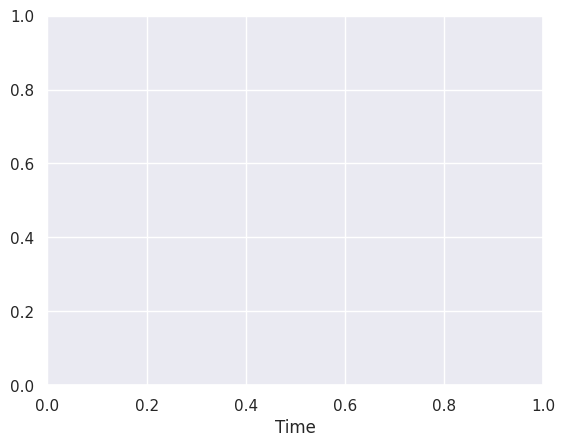

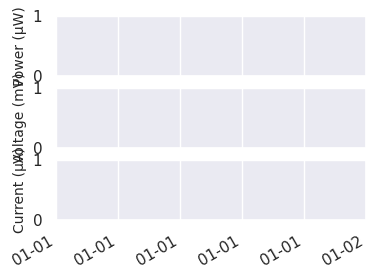

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
#mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Limits for graphs
VOLTAGE_LIM = 0.2
CURRENT_LIM = 40
POWER_LIM = 4

plt.close()
plt.xlabel("Time")
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(4,3), sharex=False)
fig.autofmt_xdate()

volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dotted'
amp_color1 = 'tab:red'
amp_style1='dashed'
amp_color2 = 'tab:orange'
amp_style2='dashdot'

ax1.fmt_xdata = md.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax1.set_ylabel("Power")
ax1.grid(True)

ax2.fmt_xdata = md.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax2.set_ylabel("Power")
ax2.grid(True)

ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))

ax1.set_ylabel("Power (μW)", fontsize=10)
ax2.set_ylabel("Voltage (mV)", fontsize=10)
ax3.set_ylabel("Current (μA)", fontsize=10)
#ax3.set_xlabel("Date", fontsize=10)
ax3.grid(True)
#print('max power: ',max(max(1E6*df['power1']),max(1E6*df['power2'])))
#ax3.set_ylim(0, 4)
ax1.plot(mv1.index, mv2["power_pred"] * 1E-3, color=volt_color1, ls = volt_style1)
ax1.plot(mv1.index, mv2['power'] * 1E-3, color=volt_color2, ls = volt_style2)
ax1.legend(['predictions','actual'], loc='upper right', prop={'size': 6})

ax2.plot(mv1.index, mv2["voltage_pred"] * 1E-2, color=volt_color1, ls = volt_style1)
ax2.plot(mv1.index, mv2['V1 [mV]'] * 1E-2, color=volt_color2, ls = volt_style2)
ax2.legend(['predictions','actual'], loc='upper right', prop={'size': 6})

ax3.plot(mv1.index, mv2["current_pred"] * 1E-2, color=volt_color1, ls = volt_style1)
ax3.plot(mv1.index, mv2['I1L [μA]'] * 1E-2, color=volt_color2, ls = volt_style2)
ax3.legend(['predictions','actual'], loc='upper right', prop={'size': 6})
#ax3.legend(['actual'], loc='upper right', prop={'size': 6})


#Plot error
#ax3.plot(mv1['timestamp'], mv1['error']/mv1['power'], color=volt_color2, ls = volt_style2)
#ax3.legend(['error'], loc='upper right', prop={'size': 6})

ax3.tick_params(axis='x', labelsize=6, rotation=0)
#ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
#ax3.set_xlim(mv.index[0], datetime.date(2020,5,19))
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

plt.tight_layout(pad=0.6, w_pad=0.5, h_pad=2.0)
plt.subplots_adjust(hspace=0.50)
plt.savefig('twobat.pdf')
plt.close()


In [ ]:
from keras.models import load_model

def quantile_loss(y_true, y_pred, quantile = 0.5):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/lstm8_60min_quant50", custom_objects={'quantile_loss': quantile_loss})
predictions = model.predict(np.concatenate((X_train, X_valid, X_test)))
mv1 = df
mv1["power_pred_med"] = predictions[:, 0]
mv1["voltage_pred_med"] = predictions[:, 1]
mv1["current_pred_med"] = predictions[:, 2]

def quantile_loss(y_true, y_pred, quantile = 0.05):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/lstm8_60min_quant5", custom_objects={'quantile_loss': quantile_loss})
predictions = model.predict(np.concatenate((X_train, X_valid, X_test)))
mv1 = df
mv1["power_pred_lower"] = predictions[:, 0]
mv1["voltage_pred_lower"] = predictions[:, 1]
mv1["current_pred_lower"] = predictions[:, 2]

def quantile_loss(y_true, y_pred, quantile = 0.75):
    error = y_true - y_pred
    return K.mean(K.maximum(quantile * error, (quantile - 1) * error), axis=-1)

model = load_model("drive/MyDrive/jLab Shared Docs/MFC Modeling/lstm8_60min_quant75", custom_objects={'quantile_loss': quantile_loss})
predictions = model.predict(np.concatenate((X_train, X_valid, X_test)))
mv1 = df
mv1["power_pred_upper"] = predictions[:, 0]
mv1["voltage_pred_upper"] = predictions[:, 1]
mv1["current_pred_upper"] = predictions[:, 2]


mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
mv2 = mv1



115/115 [==============================] - 1s 4ms/step


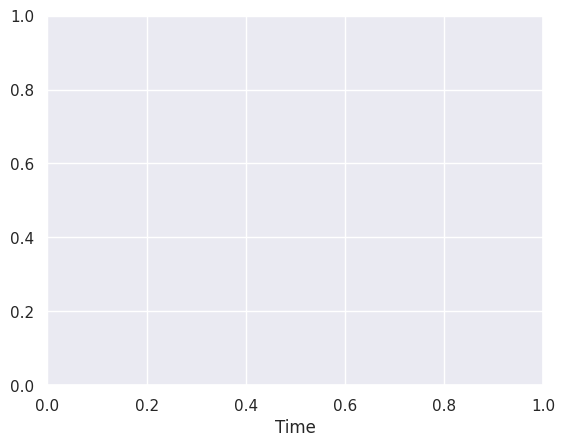

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
#mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Limits for graphs
VOLTAGE_LIM = 0.2
CURRENT_LIM = 40
POWER_LIM = 4

line_width = 0.5
plt.title("1 hour prediction interval")

plt.close()
plt.xlabel("Time")
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(4,3), sharex=False)
fig.autofmt_xdate()

volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dashed'
volt_color3= 'tab:red'
volt_style3 = 'dashed'
volt_color4= 'tab:orange'
volt_style4 = 'dashed'

#amp_color1 = 'tab:red'
#amp_style1='dashed'
#amp_color2 = 'tab:orange'
#amp_style2='dashdot'

ax1.fmt_xdata = md.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax1.grid(True)

ax2.fmt_xdata = md.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax2.grid(True)

ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
ax3.grid(True)

ax1.set_ylabel("Power (μW)", fontsize=7.5, labelpad = 2.5)
ax2.set_ylabel("Voltage (mV)", fontsize=7.5, labelpad = 2.5)
ax3.set_ylabel("Current (μA)", fontsize=7.5, labelpad = 2.5)
#ax3.set_xlabel("Date", fontsize=10)

ax1.set_ylim(0, 1.5)
ax2.set_ylim(0, 60)
ax3.set_ylim(0, 40)

#ax3.set_xlim([datetime.date(2021, 12, 12), datetime.date(2021, 12, 14)])
ax1.set_xlim([mv1.index[0], mv1.index[-1]])
ax2.set_xlim([mv1.index[0], mv1.index[-1]])
ax3.set_xlim([mv1.index[0], mv1.index[-1]])

ax1.plot(mv1.index, mv2["power_pred_lower"] * 1E-3, color='tab:red', ls = volt_style3, linewidth=line_width)
ax1.plot(mv1.index, mv2["power_pred_upper"] * 1E-3, color='tab:orange', ls = volt_style4, linewidth=line_width)
ax1.plot(mv1.index, mv2["power"] * 1E-3, color='tab:blue', ls = 'solid', linewidth=line_width)
ax1.plot(mv1.index, mv2["power_pred_med"] * 1E-3, color='tab:green', ls = volt_style2, linewidth=line_width)
ax1.fill_between(mv1.index, mv2["power_pred_lower"] * 1E-3, mv2["power_pred_upper"] * 1E-3, color='grey', alpha=0.5)
#ax1.legend(['lower bound', 'upper bound', 'actual', 'median predictions'], loc='lower center', prop={'size': 5.5}, ncol=2)

ax2.plot(mv1.index, mv2["voltage_pred_lower"] * 1E-2, color='tab:red', ls = volt_style3, linewidth=line_width)
ax2.plot(mv1.index, mv2["voltage_pred_upper"] * 1E-2, color='tab:orange', ls = volt_style4, linewidth=line_width)
ax2.plot(mv1.index, mv2['V1 [mV]'] * 1E-2, color='tab:blue', ls = 'solid', linewidth=line_width)
ax2.plot(mv1.index, mv2["voltage_pred_med"] * 1E-2, color='tab:green', ls = volt_style2, linewidth=line_width)
ax2.fill_between(mv1.index, mv2["voltage_pred_lower"] * 1E-2, mv2["voltage_pred_upper"] * 1E-2, color='grey', alpha=0.5)
ax2.legend(['lower bound', 'upper bound', 'ground truth', 'median prediction'], loc='lower left', prop={'size': 6.6}, ncol=2, columnspacing=0.5)

ax3.plot(mv1.index, mv2["current_pred_lower"] * 1E-2, color='tab:red', ls = volt_style3, linewidth=line_width)
ax3.plot(mv1.index, mv2["current_pred_upper"] * 1E-2, color='tab:orange', ls = volt_style4, linewidth=line_width)
ax3.plot(mv1.index, mv2['I1L [μA]'] * 1E-2, color='tab:blue', ls = 'solid', linewidth=line_width)
ax3.plot(mv1.index, mv2["current_pred_med"] * 1E-2, color='tab:green', ls = volt_style2, linewidth=line_width)
ax3.fill_between(mv1.index, mv2["current_pred_lower"] * 1E-2, mv2["current_pred_upper"] * 1E-2, color='grey', alpha=0.5)
#ax3.legend(['lower bound', 'upper bound', 'actual', 'median predictions'], loc='upper right', prop={'size': 5.5}, ncol=1)


#Plot error
#ax3.plot(mv1['timestamp'], mv1['error']/mv1['power'], color=volt_color2, ls = volt_style2)
#ax3.legend(['error'], loc='upper right', prop={'size': 6})

ax3.tick_params(axis='x', labelsize=7.5, rotation=0, pad = 0.1)
ax3.set_xticks(list(ax3.get_xticks()) + [ax3.get_xlim()[0], ax3.get_xlim()[1]])
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

ax1.tick_params(axis='y', labelsize=7.5, rotation=0, pad = 0.1)
ax2.tick_params(axis='y', labelsize=7.5, rotation=0, pad = 0.1)
ax3.tick_params(axis='y', labelsize=7.5, rotation=0, pad = 0.1)

plt.tight_layout(pad=0.3, w_pad=0.5, h_pad=0.1)
#plt.subplots_adjust(hspace=0.15)
plt.savefig('twobat.pdf')
plt.close()